In [1]:
import numpy as np
import pandas as pd 

In [2]:
!pip install tensorflow

You should consider upgrading via the '/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/bin/python -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re
from nltk.stem import WordNetLemmatizer

In [4]:
df = pd.read_csv('./data/IMDB_Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# ----- Get labels -----
y = np.int32(df.sentiment.astype('category').cat.codes.to_numpy())
# ----- Get number of classes -----
num_classes = np.unique(y).shape[0]
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

# Preprocess text

Before we apply any algorithm, we need to have a cleaned data set. In our case with text data, it is essential to perform preprocessing steps in order to increase the performance of the algorithms. The steps we perform are:

1. remove br tags
2. remove all single characters
3. substituting multiple spaces with single space
4. remove links
5. remove words containing numbers
6. converting to lowercase
7. lemmatization

The final preprocessing step is the lemmatization. In lemmatization, we reduce the word into dictionary root form. 
For instance "cats" is converted into "cat". Lemmatization is done in order to avoid creating features that are semantically similar but syntactically different.

For instance, we don't want two different features named "cats" and "cat", which are semantically similar, therefore we perform lemmatization.

In [7]:
stemmer = WordNetLemmatizer()
def custom_standardization(text):
    
    text = re.sub('<br />', ' ', str(text))
    
    text = re.sub(r'\W', ' ', str(text))
    
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    # converting to Lowercase
    text = text.lower()
    
    # lemmatization
    text = text.split()

    text = [stemmer.lemmatize(word) for word in text]
    text = ' '.join(text)
    
    return text
    pass

In [8]:
df['review'] = df.review.apply(custom_standardization)

In [9]:
#removing the stopwords

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=stopwords.words('english')

stop=set(stopwords.words('english'))
print(stop)

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'most', "weren't", 'other', 'won', 'out', "you'd", 'then', 'at', 'weren', 'had', 'where', "hadn't", 'a', 'for', 'aren', 'can', 'ourselves', 'by', 'or', 'once', 'only', 't', "won't", 'theirs', 'shouldn', 'you', 'be', "she's", 'why', 'this', 'me', 'that', 'y', 'under', 'during', 'is', 'how', 'has', 'so', 'the', 'between', 'any', 'all', 'yourself', "couldn't", 'nor', "haven't", 'from', 'about', 'until', 'do', "needn't", 'hadn', 'here', 'did', 'more', "should've", 'what', 'isn', "shouldn't", 'they', "wouldn't", 'such', 'didn', "aren't", 'm', 'should', 'further', 'were', "didn't", "it's", "hasn't", 'their', 'himself', 'those', 'against', "that'll", 've', 'doesn', 'mustn', "you'll", 'than', 'its', 'into', "you're", "mustn't", 'after', 'herself', 'am', 'and', 'to', 'few', 'same', 're', 'your', 'yours', 'she', 'have', 'no', "shan't", 'too', 'just', 'below', 'off', 'whom', 'having', 'while', 'above', 'itself', 'not', 'but', 'up', "wasn't", 'he', 'when', 'does', 'through', 'my', 'which', 'there

In [10]:
df.head()

,review,sentiment
0,one reviewer ha mentioned watching oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wa wonderful way spend time hot summer...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


# EDA

In [11]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

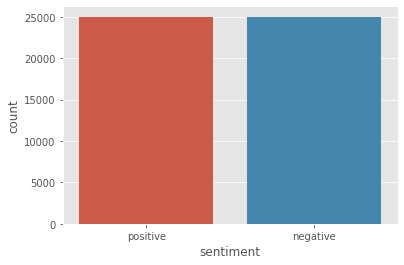

In [12]:
import seaborn as sns
sns.countplot(df.sentiment)

In [13]:
## we can see that dataset is balanced

In [14]:
df.describe()

,review,sentiment
count,50000,50000
unique,49573,2
top,loved today show wa variety solely cooking wou...,negative
freq,5,25000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### checking distribution of positive and negative sentiments in train and test data

/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

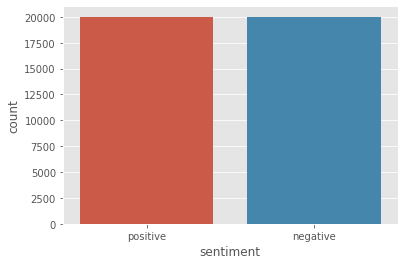

In [16]:
## Train data is also equally balanced.
## TODO: split through stratify splitting
## TODO: validation part also need to be there
## TODO: K-FOLD

train = df[:40000]
test = df[40000:]

sns.countplot(train.sentiment)


/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

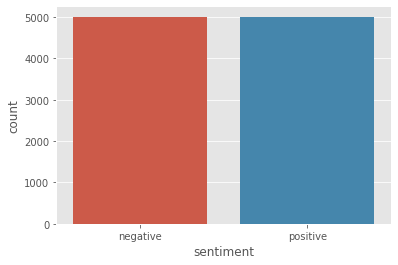

In [17]:
## test data is also equally balanced
sns.countplot(test.sentiment)

### checking text length size has any effect on sentiment.

<AxesSubplot:xlabel='text_len', ylabel='Count'>

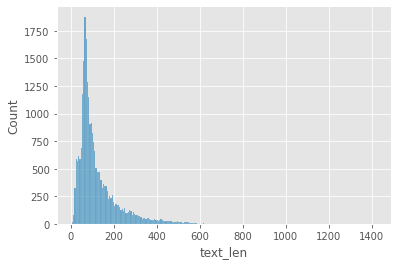

In [18]:

train_eda= df
train_eda['text_len'] = df['review'].astype(str).apply(len)
train_eda['text_len'] = df['review'].apply(lambda x: len(str(x).split()))

pos = train_eda[train_eda['sentiment']=='positive']
neg = train_eda[train_eda['sentiment']=='negative']

sns.histplot(data=pos, x="text_len")

<AxesSubplot:xlabel='text_len', ylabel='Count'>

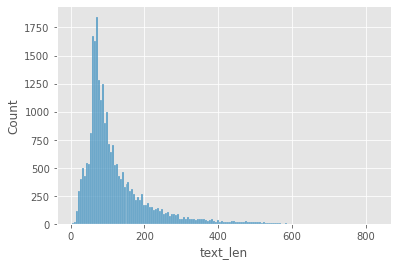

In [19]:
sns.histplot(data=neg, x="text_len")

/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='text_len'>

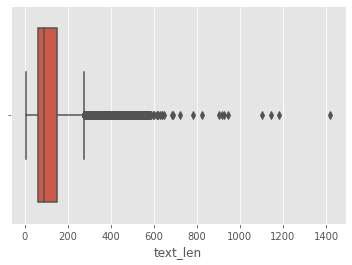

In [20]:
sns.boxplot(pos['text_len'])


/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='text_len'>

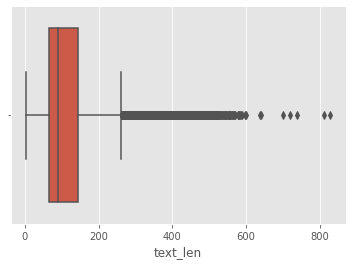

In [21]:
sns.boxplot(neg['text_len'])

### Check top unigram words for positive and negative reviews

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

pos_unigrams = get_top_n_words(pos['review'],20)
neg_unigrams = get_top_n_words(neg['review'],20)

<AxesSubplot:xlabel='count', ylabel='review'>

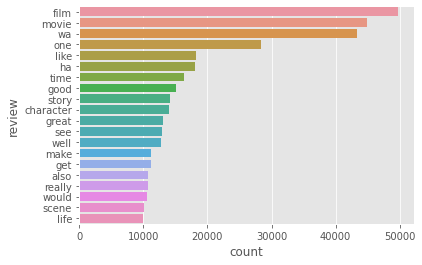

In [23]:
df1 = pd.DataFrame(pos_unigrams, columns = ['review' , 'count'])
df1.groupby('review').sum()['count']
sns.barplot(x="count", y="review", data=df1)

<AxesSubplot:xlabel='count', ylabel='review'>

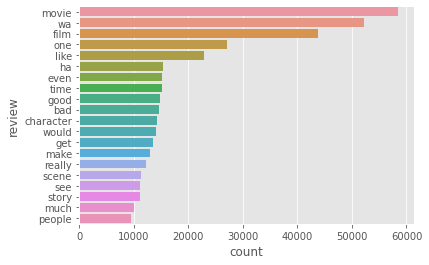

In [24]:
df1 = pd.DataFrame(neg_unigrams, columns = ['review' , 'count'])
df1.groupby('review').sum()['count']
sns.barplot(x="count", y="review", data=df1)

### Check top bigrams for positive and negative reviews

In [25]:
def get_top_n_gram(corpus,ngram_range,n=None):    
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

pos_bigrams = get_top_n_gram(pos['review'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['review'],(2,2),20)

<AxesSubplot:xlabel='count', ylabel='review'>

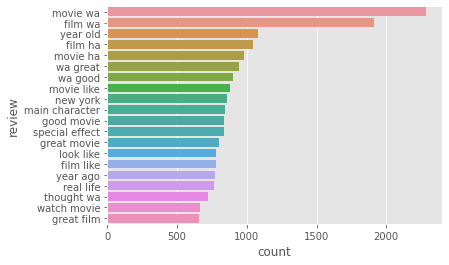

In [26]:
df1 = pd.DataFrame(pos_bigrams, columns = ['review' , 'count'])
df1.groupby('review').sum()['count']
sns.barplot(x="count", y="review", data=df1)

<AxesSubplot:xlabel='count', ylabel='review'>

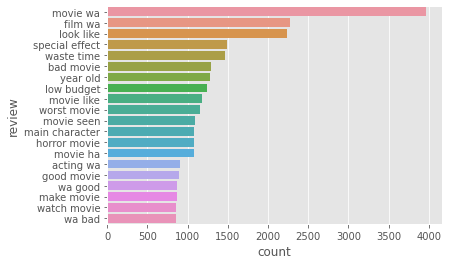

In [27]:
df1 = pd.DataFrame(neg_bigrams, columns = ['review' , 'count'])
df1.groupby('review').sum()['count']
sns.barplot(x="count", y="review", data=df1)

### Check top trigrams for positive and negative reviews

In [28]:
pos_trigrams = get_top_n_gram(pos['review'],(3,3),20)
neg_trigrams = get_top_n_gram(neg['review'],(3,3),20)

<AxesSubplot:xlabel='count', ylabel='review'>

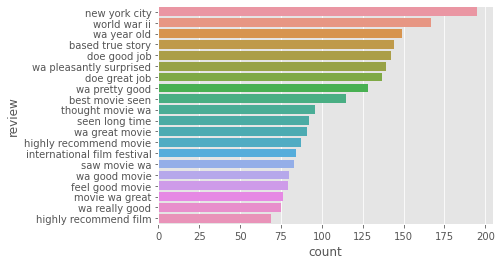

In [29]:
df1 = pd.DataFrame(pos_trigrams, columns = ['review' , 'count'])
df1.groupby('review').sum()['count']
sns.barplot(x="count", y="review", data=df1)

<AxesSubplot:xlabel='count', ylabel='review'>

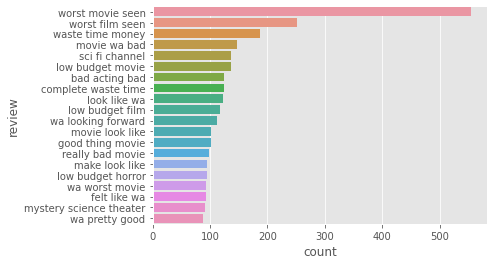

In [30]:
df1 = pd.DataFrame(neg_trigrams, columns = ['review' , 'count'])
df1.groupby('review').sum()['count']
sns.barplot(x="count", y="review", data=df1)

# Vectorization

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
norm_train_reviews=df.review[:40000]
norm_test_reviews=df.review[40000:]

In [33]:
## Bag of words model

#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)


BOW_cv_train: (40000, 6106118)
BOW_cv_test: (10000, 6106118)


In [34]:
vocab=cv.get_feature_names() ## to get feature names
vocab[:10]

['__',
 '__ actually',
 '__ actually better',
 '__ yes',
 '__ yes prudhomme',
 '___ adventure',
 '___ adventure sam',
 '___ movie',
 '___ movie thought',
 '____ anenokoji']

In [35]:
cv_train_reviews.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6106118)
Tfidf_test: (10000, 6106118)


In [37]:
from sklearn.preprocessing import LabelBinarizer

#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [38]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [39]:
from sklearn.linear_model import LogisticRegression,SGDClassifier

#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [40]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


In [41]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7473
lr_tfidf_score : 0.7471


In [42]:
## BERT
!pip install torch
!pip install ipywidgets


You should consider upgrading via the '/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/bin/python -m pip install --upgrade pip' command.


In [43]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[', 'CLS', ']', 'Here', 'is', 'the', 'sentence', 'I', 'want', 'embeddings', 'for.', '[', 'SEP', ']']


## Automatic EDA 

In [44]:
!pip3 install pandas-profiling

You should consider upgrading via the '/Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/bin/python -m pip install --upgrade pip' command.


In [45]:
from pandas_profiling import ProfileReport
df = pd.DataFrame(np.random.rand(100, 2), columns=["review", "sentiment"])
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)


In [46]:
# profile.to_widgets()
# profile.to_notebook_iframe()
profile.to_file("eda_report.html")


Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
### Word Cloud

In [49]:
!pip3 install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  ERROR: Command errored out with exit status 1:
   command: /Users/stalaviya/MachineLearning/git_machine_learning/sentiment_research/venv3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/00/1y4f2_3j0rz7mzhz_rwrcrnh0000gq/T/pip-install-qlvg95t3/wordcloud_dede9ce7ba834e21b4c2b44a7724669c/setup.py'"'"'; __file__='"'"'/private/var/folders/00/1y4f2_3j0rz7mzhz_rwrcrnh0000gq/T/pip-install-qlvg95t3/wordcloud_dede9ce7ba834e21b4c2b44a7724669c/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/00/1y4f2_3j0rz7mzhz_rwrcrnh0000gq/T/pip-wheel-tkckeep4
       cwd: /private/var/folders/00/1y4f2_3j0rz7mzhz_rwrcrnh0000gq/T/pip-install-qlvg95t3/wordcloud

In [58]:
from wordcloud import WordCloud, STOPWORDS


In [63]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in pos_unigrams:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
      


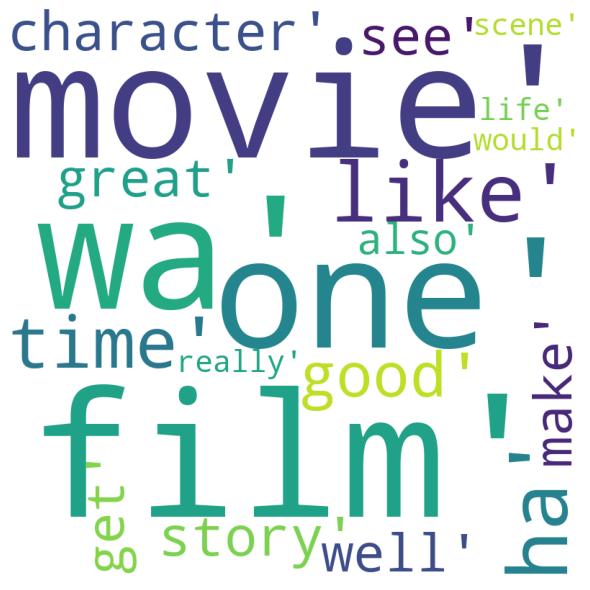

In [64]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [65]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in neg_unigrams:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
      

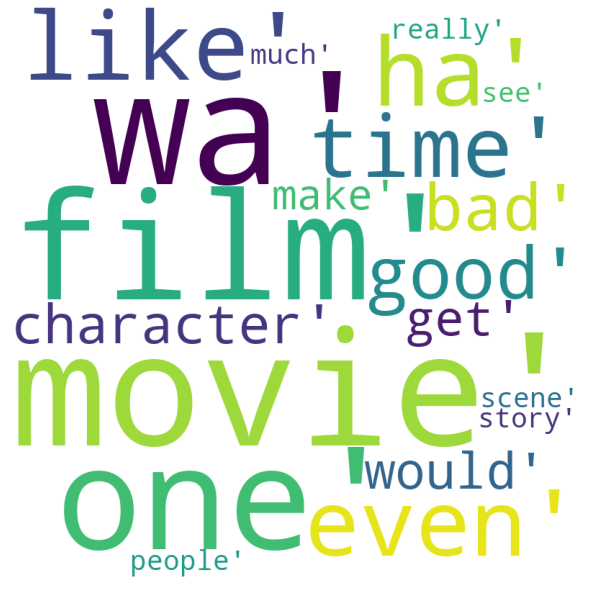

In [66]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()